In [1]:
!pip install fedot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 60.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.2/416.2 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.2/296.2 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.0/394.0 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import logging # логирование

from fedot import Fedot # автоматизированное обучение

In [3]:
Fedot?

Level 100:root:Topological features operation requires extra dependencies for time series forecasting, which are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'


2025-04-04 17:48:03,777 - Topological features operation requires extra dependencies for time series forecasting, which are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
  0%|          | 3/100000 [01:01<567:11:07, 20.42s/trial, best loss: 78338.47245005131]


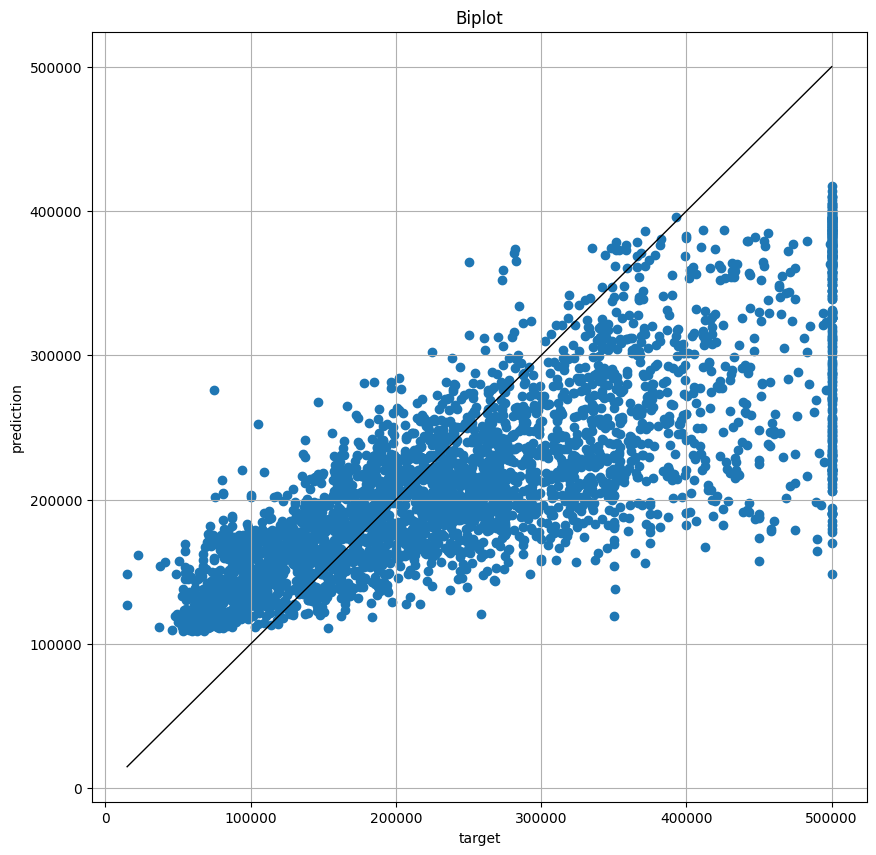

{'rmse': 90958.991}


In [4]:
from fedot.core.data.data import InputData #  для представления данных в формате, понятном FEDOT
from fedot.core.data.data_split import train_test_data_setup # для разделения данных на обучающую и тестовую выборки
from fedot.core.repository.tasks import TaskTypesEnum, Task
# тип решаемой задачи
# (Классификация (classification), Регрессия (regression),Прогнозирование временных рядов (ts_forecasting))
# Task - класс для создания объекта задачи

from fedot.core.utils import fedot_project_root # доступ к корневой директории проекта FEDOT


def run_regression_example(visualise: bool = False, with_tuning: bool = True,
                           timeout: float = 2., preset: str = 'auto'):
    data_path = f'https://raw.githubusercontent.com/timothypesi/Data-Sets-For-Machine-Learning-/refs/heads/main/california_housing_train.csv'

    data = InputData.from_csv(data_path,
                              task=Task(TaskTypesEnum.regression))
    train, test = train_test_data_setup(data)
    problem = 'regression'

    composer_params = {'history_dir': 'custom_history_dir', 'preset': preset}
    auto_model = Fedot(problem=problem, seed=42, timeout=timeout, logging_level=logging.FATAL,
                       with_tuning=with_tuning, **composer_params)

    auto_model.fit(features=train, target='median_house_value') # median_house_value
    prediction = auto_model.predict(features=test)
    if visualise:
        auto_model.history.save('saved_regression_history.json')
        auto_model.plot_prediction()
    print(auto_model.get_metrics())
    return prediction


if __name__ == '__main__':
    run_regression_example(visualise=True)

In [ ]:
from fedot.core.pipelines.node import PipelineNode # для создания отдельных узлов пайплайна
from fedot.core.pipelines.pipeline import Pipeline # для создания и управления целым пайплайном


def regression_three_depth_manual_pipeline():
    """
    Returns pipeline with the following structure:

    .. image:: img_regression_pipelines/three_depth_manual.png
      :width: 55%

    Where rf - random forest, dtreg - tree regression, knn - K nearest neighbors regression,
   """
    rfr_primary = PipelineNode('rfr')
    knn_primary = PipelineNode('knnreg')

    dtreg_secondary = PipelineNode('dtreg', nodes_from=[rfr_primary])
    rfr_secondary = PipelineNode('rfr', nodes_from=[knn_primary])

    knnreg_root = PipelineNode('knnreg', nodes_from=[dtreg_secondary, rfr_secondary])

    pipeline = Pipeline(knnreg_root)

    return pipeline


def regression_ransac_pipeline():
    """
    Returns pipeline with the following structure:

    .. image:: img_regression_pipelines/ransac.png
      :width: 55%

    Where ransac_lin_reg - ransac algorithm
   """
    node_scaling = PipelineNode('scaling')
    node_ransac = PipelineNode('ransac_lin_reg', nodes_from=[node_scaling])
    node_ridge = PipelineNode('lasso', nodes_from=[node_ransac])
    pipeline = Pipeline(node_ridge)
    return pipeline

In [ ]:
from datetime import timedelta

import numpy as np
from golem.core.tuning.sequential import SequentialTuner
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from examples.simple.regression.regression_pipelines import regression_ransac_pipeline
from fedot.core.data.data import InputData
from fedot.core.pipelines.tuning.tuner_builder import TunerBuilder # подстройка гиперпараметров модели
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.metrics_repository import RegressionMetricsEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum
from fedot.core.utils import set_random_seed
from fedot.utilities.synth_dataset_generator import regression_dataset


def get_regression_dataset(features_options, samples_amount=250,
                           features_amount=5):
    """
    Prepares four numpy arrays with different scale features and target
    :param samples_amount: Total amount of samples in the resulted dataset.
    :param features_amount: Total amount of features per sample.
    :param features_options: The dictionary containing features options in key-value
    format:
        - informative: the amount of informative features;
        - bias: bias term in the underlying linear model;
    :return x_data_train: features to train
    :return y_data_train: target to train
    :return x_data_test: features to test
    :return y_data_test: target to test
    """

    x_data, y_data = regression_dataset(samples_amount=samples_amount,
                                        features_amount=features_amount,
                                        features_options=features_options,
                                        n_targets=1,
                                        noise=0.0, shuffle=True)

    # Changing the scale of the data
    for i, coeff in zip(range(0, features_amount),
                        np.random.randint(1, 100, features_amount)):
        # Get column
        feature = np.array(x_data[:, i])

        # Change scale for this feature
        rescaled = feature * coeff
        x_data[:, i] = rescaled

    # Train and test split
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,
                                                        test_size=0.3)

    return x_train, y_train, x_test, y_test


def run_experiment(pipeline, tuner):
    samples = [50, 250, 150]
    features = [1, 5, 10]
    options = [{'informative': 1, 'bias': 0.0},
               {'informative': 2, 'bias': 2.0},
               {'informative': 1, 'bias': 3.0}]

    for samples_amount, features_amount, features_options in zip(samples, features, options):
        print('=======================================')
        print(f'\nAmount of samples {samples_amount}, '
              f'amount of features {features_amount}, '
              f'additional options {features_options}')

        x_train, y_train, x_test, y_test = get_regression_dataset(features_options,
                                                                  samples_amount,
                                                                  features_amount)

        # Define regression task
        task = Task(TaskTypesEnum.regression)

        # Prepare data to train the model
        train_input = InputData(idx=np.arange(0, len(x_train)),
                                features=x_train,
                                target=y_train,
                                task=task,
                                data_type=DataTypesEnum.table)

        predict_input = InputData(idx=np.arange(0, len(x_test)),
                                  features=x_test,
                                  target=None,
                                  task=task,
                                  data_type=DataTypesEnum.table)

        # Fit it
        pipeline.fit(train_input)

        # Predict
        predicted_values = pipeline.predict(predict_input)
        pipeline_prediction = predicted_values.predict

        mae_value = mean_absolute_error(y_test, pipeline_prediction)
        print(f'Mean absolute error - {mae_value:.4f}\n')

        if tuner is not None:
            print('Start tuning process ...')
            pipeline_tuner = (
                TunerBuilder(task)
                .with_tuner(tuner)
                .with_metric(RegressionMetricsEnum.MAE)
                .with_iterations(50)
                .with_timeout(timedelta(seconds=50))
                .build(train_input)
            )
            tuned_pipeline = pipeline_tuner.tune(pipeline)

            # Fit it
            tuned_pipeline.fit(train_input)

            # Predict
            predicted_values_tuned = tuned_pipeline.predict(predict_input)
            preds_tuned = predicted_values_tuned.predict

            mae_value = mean_absolute_error(y_test, preds_tuned)

            print('Obtained metrics after tuning:')
            print(f'MAE - {mae_value:.4f}\n')

        pipeline.unfit()


# Script for testing is pipeline can process different datasets for regression task
if __name__ == '__main__':
    set_random_seed(2020)

    run_experiment(regression_ransac_pipeline(), tuner=SequentialTuner)

# Задачу регрессии

In [5]:
from fedot import Fedot

In [6]:
from fedot.core.data.data import InputData
import pandas as pd

data_path = f'https://raw.githubusercontent.com/timothypesi/Data-Sets-For-Machine-Learning-/refs/heads/main/california_housing_train.csv'

df = pd.read_csv(data_path)

In [7]:
data = InputData.from_dataframe(df.drop(columns=['median_house_value']),
                                df['median_house_value'],
                                task=Task(TaskTypesEnum.regression))
train, test = train_test_data_setup(data)

In [8]:
model = Fedot(problem='regression', seed=42, timeout=5)

In [9]:
best_pipeline = model.fit(train)

Level 45:root:ApiComposer - Initial pipeline was fitted in 14.4 sec.


2025-04-04 17:59:49,844 - ApiComposer - Initial pipeline was fitted in 14.4 sec.


Level 45:root:ApiComposer - Taking into account n_folds=5, estimated fit time for initial assumption is 71.8 sec.


2025-04-04 17:59:49,850 - ApiComposer - Taking into account n_folds=5, estimated fit time for initial assumption is 71.8 sec.


Level 45:root:AssumptionsHandler - Preset was changed to fast_train due to fit time estimation for initial model.


2025-04-04 17:59:49,855 - AssumptionsHandler - Preset was changed to fast_train due to fit time estimation for initial model.


Level 45:root:ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 5 min. Set of candidate models: ['adareg', 'dtreg', 'knnreg', 'lasso', 'linear', 'normalization', 'pca', 'ransac_lin_reg', 'rfr', 'ridge', 'scaling', 'sgdr'].


2025-04-04 17:59:49,871 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 5 min. Set of candidate models: ['adareg', 'dtreg', 'knnreg', 'lasso', 'linear', 'normalization', 'pca', 'ransac_lin_reg', 'rfr', 'ridge', 'scaling', 'sgdr'].


Level 45:root:ApiComposer - Timeout is too small for composing and is skipped because fit_time is 71.83638 sec.


2025-04-04 17:59:49,950 - ApiComposer - Timeout is too small for composing and is skipped because fit_time is 71.83638 sec.


Level 45:root:ApiComposer - Hyperparameters tuning started with 5 min. timeout


2025-04-04 17:59:49,969 - ApiComposer - Hyperparameters tuning started with 5 min. timeout


Level 45:root:SimultaneousTuner - Initial graph: {'depth': 2, 'length': 2, 'nodes': [rfr, scaling]}
rfr - {'n_jobs': 2}
scaling - {} 
Initial metric: [88811.434]


2025-04-04 18:00:39,776 - SimultaneousTuner - Initial graph: {'depth': 2, 'length': 2, 'nodes': [rfr, scaling]}
rfr - {'n_jobs': 2}
scaling - {} 
Initial metric: [88811.434]
  0%|          | 8/100000 [04:09<865:55:40, 31.18s/trial, best loss: 78278.6588807288]


Level 45:root:SimultaneousTuner - Final graph: {'depth': 2, 'length': 2, 'nodes': [rfr, scaling]}
rfr - {'n_jobs': 2, 'bootstrap': False, 'max_features': 0.36307448433256057, 'min_samples_leaf': 3, 'min_samples_split': 8}
scaling - {}


2025-04-04 18:05:10,893 - SimultaneousTuner - Final graph: {'depth': 2, 'length': 2, 'nodes': [rfr, scaling]}
rfr - {'n_jobs': 2, 'bootstrap': False, 'max_features': 0.36307448433256057, 'min_samples_leaf': 3, 'min_samples_split': 8}
scaling - {}


Level 45:root:SimultaneousTuner - Final metric: 78278.659


2025-04-04 18:05:10,900 - SimultaneousTuner - Final metric: 78278.659


Level 45:root:ApiComposer - Hyperparameters tuning finished


2025-04-04 18:05:10,907 - ApiComposer - Hyperparameters tuning finished


Level 45:root:ApiComposer - Model generation finished


2025-04-04 18:05:11,459 - ApiComposer - Model generation finished


Level 45:root:FEDOT logger - Final pipeline was fitted


2025-04-04 18:05:17,203 - FEDOT logger - Final pipeline was fitted


Level 45:root:FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [rfr, scaling]}
rfr - {'n_jobs': 2, 'bootstrap': False, 'max_features': 0.36307448433256057, 'min_samples_leaf': 3, 'min_samples_split': 8}
scaling - {}


2025-04-04 18:05:17,210 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [rfr, scaling]}
rfr - {'n_jobs': 2, 'bootstrap': False, 'max_features': 0.36307448433256057, 'min_samples_leaf': 3, 'min_samples_split': 8}
scaling - {}


In [10]:
best_pipeline.print_structure() # rfr Random Forest Regressor

Pipeline structure:
{'depth': 2, 'length': 2, 'nodes': [rfr, scaling]}
rfr - {'n_jobs': 2, 'bootstrap': False, 'max_features': 0.36307448433256057, 'min_samples_leaf': 3, 'min_samples_split': 8}
scaling - {}


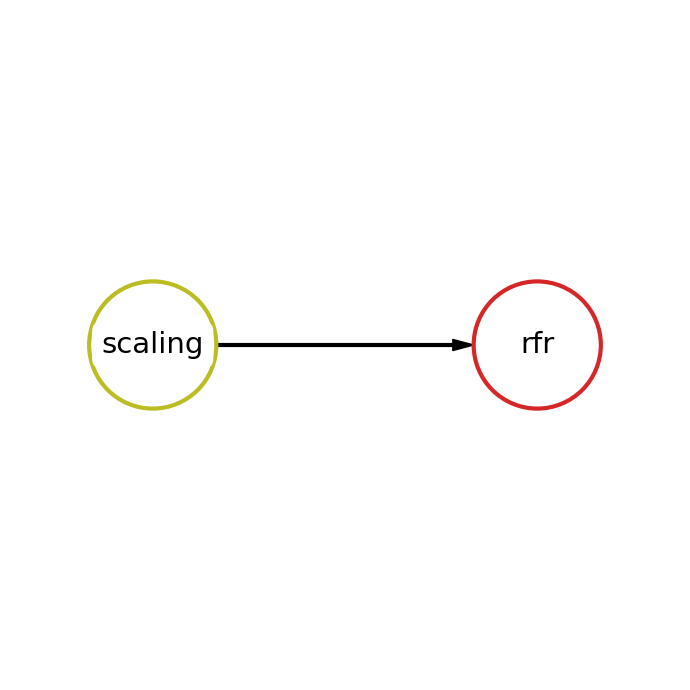

In [11]:
best_pipeline.show()

In [12]:
import json
import pickle

def convert_json_to_pkl(path_to_json, path_to_pkl):
    with open(path_to_json, "rb") as json_file:
        pipeline = json.load(json_file)
        with open(path_to_pkl, "wb") as pkl_file:
            pickle.dump(pipeline, pkl_file)

In [14]:
model.history.save("history.json");

path_to_json = "history.json"
path_to_history_pkl = "history.pkl"

convert_json_to_pkl(path_to_json, path_to_history_pkl)